# Layer visualization with PCA

In [1]:
%load_ext autoreload
%autoreload 2

## Initialization

Imports

In [2]:
import sys
sys.path.append('../')

from setup import setup_device, setup_datamodule, load_model



Please cite the following paper when using nnUNet:

Isensee, F., Jaeger, P.F., Kohl, S.A.A. et al. "nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation." Nat Methods (2020). https://doi.org/10.1038/s41592-020-01008-z


If you have questions or suggestions, feel free to open an issue at https://github.com/MIC-DKFZ/nnUNet

nnUNet_raw_data_base is not defined and nnU-Net can only be used on data for which preprocessed files are already present on your system. nnU-Net cannot be used for experiment planning and preprocessing like this. If this is not intended, please read documentation/setting_up_paths.md for information on how to set this up properly.
nnUNet_preprocessed is not defined and nnU-Net can not be used for preprocessing or training. If this is not intended, please read documentation/setting_up_paths.md for information on how to set this up.
RESULTS_FOLDER is not defined and nnU-Net cannot be used for training or inference. If this is not in

Set the device globally

In [3]:
device = setup_device('cuda:1')
print(device, type(device))

cuda:1 <class 'torch.device'>


Load a trained model

In [4]:
model = load_model('../pre-trained/trained_UNets/mnmv2-00-02_22-11-2024-v1.ckpt', device)

Loaded as Lightning module


Initialize mnmv2 dataset module

In [5]:
datamodule = setup_datamodule()

## Find mismatching segmentation

In [6]:
import torch
from monai.metrics import DiceMetric
from monai.losses import DiceCELoss
import numpy as np

batch_samples = next(iter(datamodule.test_dataloader()))
result = model(batch_samples['input'].to(device))

batch_outputs = result.cpu()
batch_targets = batch_samples['target'].cpu()
print(batch_outputs.shape, batch_targets.shape)

loss = DiceCELoss(
            softmax=True,
            sigmoid=False,
            to_onehot_y=True,
        )

print(loss(batch_outputs, batch_targets))
outputs = batch_outputs.argmax(1)
num_classes = max(result.shape[1], 2)

print("Outputs shape:", outputs.shape)  # Should be [height, width]
print("Target shape:", batch_targets.shape)  # Should be [height, width]
print("Unique values in target:", torch.unique(batch_targets))  # Should be in [0, num_classes - 1]

dsc = DiceMetric(include_background=False, reduction="none")

outputs = torch.nn.functional.one_hot(outputs, num_classes=num_classes).moveaxis(-1, 1)

out_converted = outputs.cpu()
target_converted = batch_targets.cpu()
print(out_converted.shape, target_converted.shape)
dice_score = dsc(out_converted, target_converted)

    # print(dice_score)

mismatch_threshold = 0.5
indices = [i for i, arr in enumerate(dice_score.detach().numpy()) if np.max(arr) < mismatch_threshold]

print(f"Indices where max < {mismatch_threshold}:", indices)
print(dice_score.detach().numpy()[indices])

torch.Size([32, 4, 256, 256]) torch.Size([32, 1, 256, 256])
tensor(0.4055, grad_fn=<AddBackward0>)
Outputs shape: torch.Size([32, 256, 256])
Target shape: torch.Size([32, 1, 256, 256])
Unique values in target: tensor([0, 1, 2, 3])
torch.Size([32, 4, 256, 256]) torch.Size([32, 1, 256, 256])
Indices where max < 0.5: [9, 21, 22]
[[0.3385214  0.4892562  0.        ]
 [0.43383357 0.36097562 0.        ]
 [0.         0.23955432 0.        ]]


In [7]:
import math

print("top dice score")
max_scores = [max(scores) for scores in dice_score.detach().numpy()]

np.nanargmax(max_scores)

top dice score


np.int64(16)

## Experiments

In [8]:
SAMPLE_ID = 22

Use hooks to capture hidden layer activations

In [9]:
from adapters.main import capture_convolution_layers

wrapper, layer_names = capture_convolution_layers(model, device, batch_samples['input'])

Perform dimensionality reduction

In [10]:
LAYER_NAMES = ['model.model.1.submodule.0.conv.unit0.adn.A', 'model.model.1.submodule.0.conv.unit1.adn.A', 'model.model.1.submodule.0.conv.unit3.adn.A']
# LAYER_NAME = LAYER_NAMES[0]

In [28]:
from dimensionality_reduction.utils import reduce_channels_pca

def get_pca(id):
    data = []

    for layer in LAYER_NAMES:
        layer_sample = wrapper.layer_activations[layer][id]
        reduced = reduce_channels_pca(layer_sample)
        data.append({ 'feature': reduced.transpose(2, 0, 1), 'title': layer })
    
    return data

Visualize

In [31]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.colors import ListedColormap
from visualization_utils.color_space_transformers import map_to_lab

def show_segmentation(original, target, prediction, title = ''):
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    if title:
        plt.suptitle(title)
        
    cmap_pred = ListedColormap([
        (0, 0, 0, 0),    # Class 0: transparent background
        (0, 1, 0, 0.5),  # Class 1: green with 50% opacity
        (0, 0, 1, 0.5),  # Class 2: blue with 50% opacity
        (1, 1, 0, 0.5)   # Class 3: yellow with 50% opacity
    ])
    
    img = original.transpose(1, 2, 0)
    axes[0].imshow(img, cmap='grey')
    axes[0].set_title("Original image")
    axes[0].axis("off")
    
    print(prediction.argmax(0).shape)
    axes[1].imshow(img, cmap='grey')
    axes[1].imshow(prediction.argmax(axis=0), cmap=cmap_pred, alpha=0.8)
    axes[1].set_title("Predicted segmentation")
    axes[1].axis("off")

    axes[2].imshow(img, cmap='grey')
    axes[2].imshow(target.transpose(1,2,0), cmap=cmap_pred, alpha=0.8)
    axes[2].set_title("Target segmentation")
    axes[2].axis("off")

    pred = prediction.argmax(axis=0)
    print("pred.shape", pred.shape)
    # Ground truth: remove the extra channel (shape [256,256])
    gt = target[0]
    print("gt", gt.shape)

    error = (pred != gt).astype(np.uint8)

    # Custom colormap for errors: 0 (no error) is transparent, 1 (error) is red.
    cmap_err = ListedColormap([
        (1, 1, 1, 0),    # No error: transparent
        (1, 0, 0, 0.8)   # Error: red with 80% opacity
    ])
    # axes[2].imshow(img, cmap='grey')  # Show original image
    # axes[2].imshow(pred, cmap=cmap_pred, alpha=0.7)
    # axes[2].imshow(error, cmap=cmap_err, alpha=0.8)
    # axes[2].axis("off")

    plt.tight_layout()
    plt.show()

def show_volumes(data, title = ''):
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    if title:
        plt.suptitle(title)

    for idx, data_feature in enumerate(data):
        axes[idx].imshow(map_to_lab(data_feature['feature']))
        axes[idx].set_title(data_feature['title'])
        axes[idx].axis("off")

    plt.tight_layout()
    plt.show()

(1, 256, 256) (4, 256, 256)
(256, 256)
pred.shape (256, 256)
gt (256, 256)


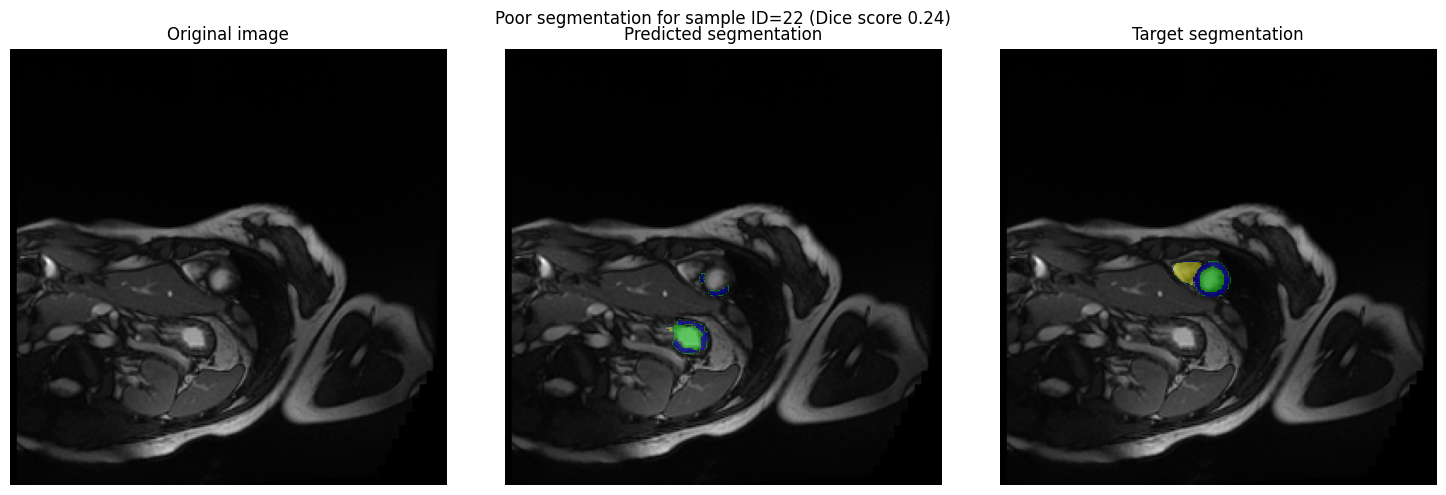

In [25]:
sample = batch_samples['input'].cpu()[SAMPLE_ID].detach().numpy()
target = batch_targets[SAMPLE_ID].detach().numpy()
prediction = batch_outputs[SAMPLE_ID].detach().numpy()
# prediction = batch_outputs[SAMPLE_ID].argmax(0).unsqueeze(0).detach().numpy()

print(target.shape, prediction.shape)
show_segmentation(sample, target=target, prediction=prediction, title=f"Poor segmentation for sample ID={SAMPLE_ID} (Dice score {np.max(dice_score.detach().numpy()[SAMPLE_ID]):.2f})")

(1, 256, 256) (4, 256, 256)
(256, 256)
pred.shape (256, 256)
gt (256, 256)


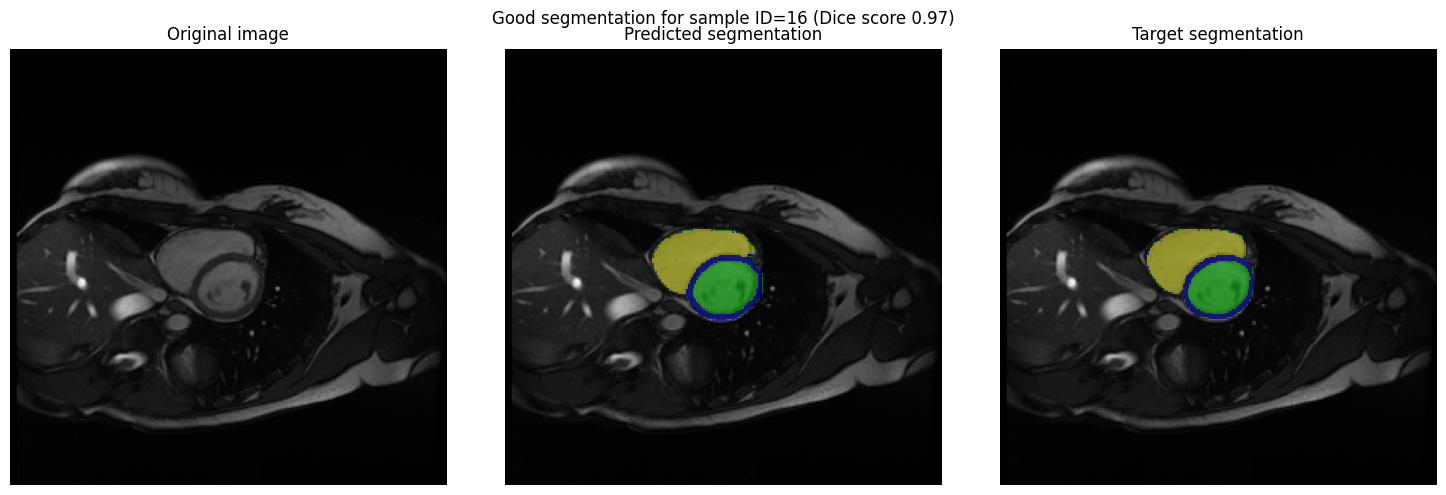

In [26]:
sample_id_2 = 16

sample = batch_samples['input'].cpu()[sample_id_2].detach().numpy()#.transpose(1, 2, 0)
target = batch_targets[sample_id_2].detach().numpy()#.transpose(1, 2, 0)
prediction = batch_outputs[sample_id_2].detach().numpy()#.argmax(0).unsqueeze(0).detach().numpy().transpose(1, 2, 0)

print(target.shape, prediction.shape)
show_segmentation(sample, target=target, prediction=prediction, title=f"Good segmentation for sample ID={sample_id_2} (Dice score {np.max(dice_score.detach().numpy()[sample_id_2]):.2f})")

/home/keller/repos/MedImSeg-Lab24/src/notebooks/../visualization_utils/color_space_transformers.py:27: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 1232 negative Z values that have been clipped to zero
  rgb_image = color.lab2rgb(lab_image)
/home/keller/repos/MedImSeg-Lab24/src/notebooks/../visualization_utils/color_space_transformers.py:27: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 49 negative Z values that have been clipped to zero
  rgb_image = color.lab2rgb(lab_image)
/home/keller/repos/MedImSeg-Lab24/src/notebooks/../visualization_utils/color_space_transformers.py:27: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 200 negative Z values that have been clipped to zero
  rgb_image = color.lab2rgb(lab_image)


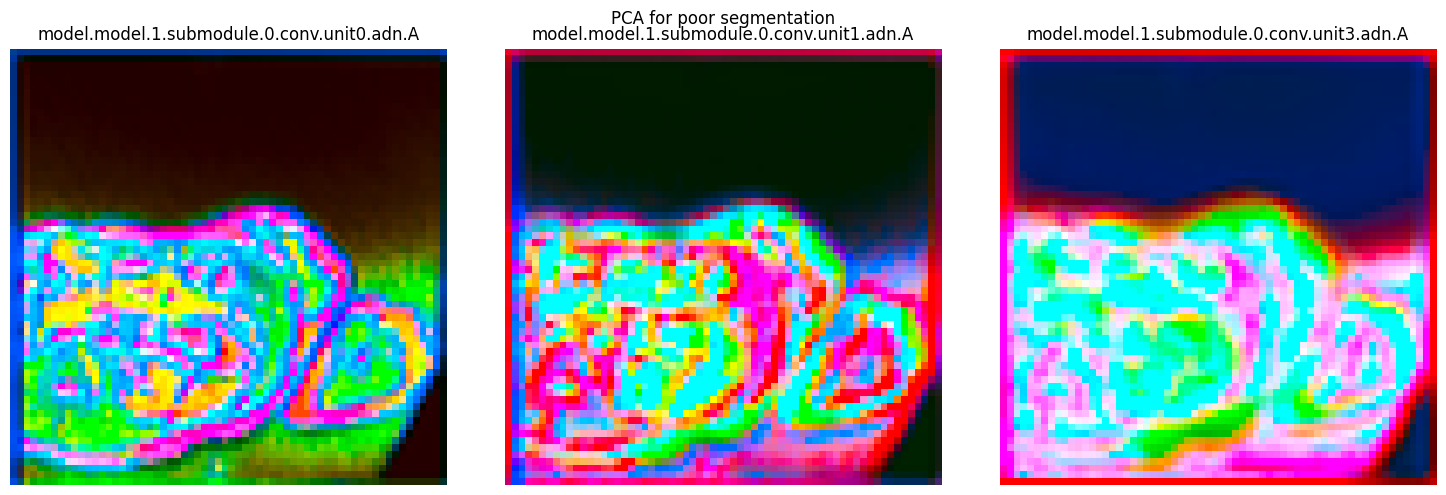

In [32]:
show_volumes(get_pca(SAMPLE_ID), "PCA for poor segmentation")

/home/keller/repos/MedImSeg-Lab24/src/notebooks/../visualization_utils/color_space_transformers.py:27: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 353 negative Z values that have been clipped to zero
  rgb_image = color.lab2rgb(lab_image)
/home/keller/repos/MedImSeg-Lab24/src/notebooks/../visualization_utils/color_space_transformers.py:27: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 32 negative Z values that have been clipped to zero
  rgb_image = color.lab2rgb(lab_image)
/home/keller/repos/MedImSeg-Lab24/src/notebooks/../visualization_utils/color_space_transformers.py:27: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 230 negative Z values that have been clipped to zero
  rgb_image = color.lab2rgb(lab_image)


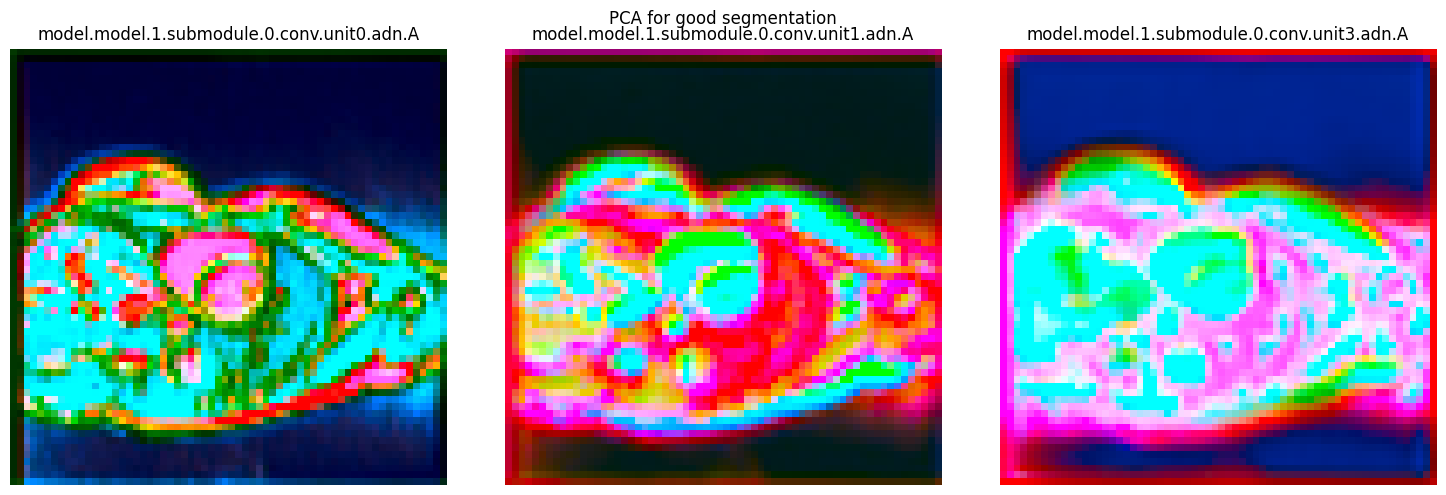

In [33]:
show_volumes(get_pca(sample_id_2), "PCA for good segmentation")